In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cst
%matplotlib inline

# Line Charge

In [68]:
def Epotential(x,y,k,x0,y0):
    """
    Electric potential line charge
    
    Inputs:
        (float) k  : line charge
        (float) x  : x coordinate potential
        (float) y  : y coordinate potential
        (float) x0 : x coordinate wire
        (float) y0 : y coordinate wire
    """
    dr = np.sqrt((x-x0)**2+(y-y0)**2)
    return (1/((4*np.pi*cst.epsilon_0))*k*np.log(dr))

In [69]:
dx = .025
dy = .025
xi = np.arange(-1,1+dx,dx)
yi = np.arange(-1,1+dy,dy)
# x,y = np.meshgrid(xi,yi)
y,x = np.mgrid[1:-1:501j,1:-1:501j]

In [70]:
potential = Epotential(x,y,cst.e,0,0)
potential[potential == np.inf] = np.nan
potential[np.isnan(potential)] = np.nanmax(potential)
potential[potential == -np.inf] = np.nan
potential[np.isnan(potential)] = np.nanmin(potential)

# dy, dx = np.gradient(potential)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy

/Users/olivier/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


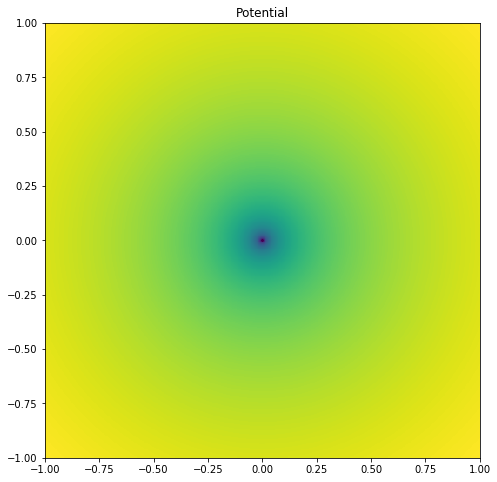

In [71]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Potential')
ax.pcolormesh(x,y,potential)
ax.set(aspect=1);

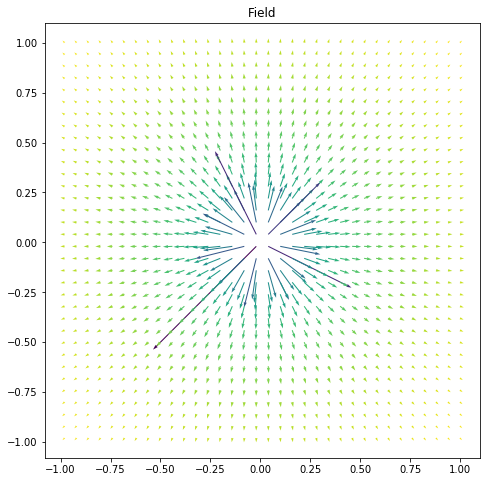

In [28]:
skip = (slice(None, None, 15), slice(None, None, 15))

fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Field')
ax.quiver(x[skip], y[skip], Ex[skip], Ey[skip], potential[skip])
ax.set(aspect=1);

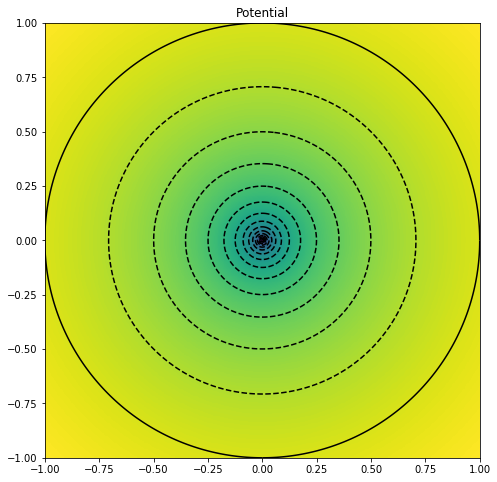

In [26]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Potential')
ax.pcolormesh(x,y,potential)
ax.contour(x, y, potential, 20, colors = 'k')
ax.set(aspect = 1);

# Minimize Field over Region

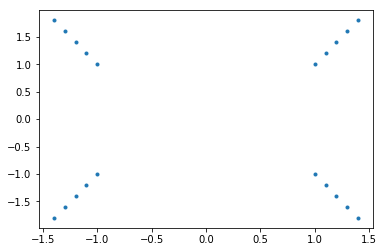

In [304]:
nwires = 5
x0wire = 1
y0wire = 1
dxwire = 0.1
dywire = 0.2
wires = np.zeros((3,4*nwires))
for n in range(nwires):
    wires[0][n] = -x0wire - n*dxwire
    wires[1][n] = y0wire + n*dywire
    wires[2][n] = 1
    wires[0][n+5] = x0wire + n*dxwire
    wires[1][n+5] = y0wire + n*dywire
    wires[2][n+5] = 1
    wires[0][n+10] = -x0wire - n*dxwire
    wires[1][n+10] = -y0wire - n*dywire
    wires[2][n+10] = -1
    wires[0][n+15] = x0wire + n*dxwire
    wires[1][n+15] = -y0wire - n*dywire
    wires[2][n+15] = -1
    
plt.plot(wires[0],wires[1],'.')

In [328]:
def wires_potential(x,y,wires):
    xwires = wires[0]
    ywires = wires[1]
    charge = wires[2]
    potential = np.zeros(x.shape)
    for xw,yw,cw in zip(xwires, ywires, charge):
        potential += Epotential(x, y, cw, xw, yw)
        
    potential[potential == np.inf] = np.nan
    potential[np.isnan(potential)] = np.nanmax(potential)
    potential[potential == -np.inf] = np.nan
    potential[np.isnan(potential)] = np.nanmin(potential)
    
    return potential

In [329]:
dx = .025
dy = .025
y,x = np.mgrid[.5:-.5:501j,.5:-.5:501j]
potential = wires_potential(x,y,wires)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy

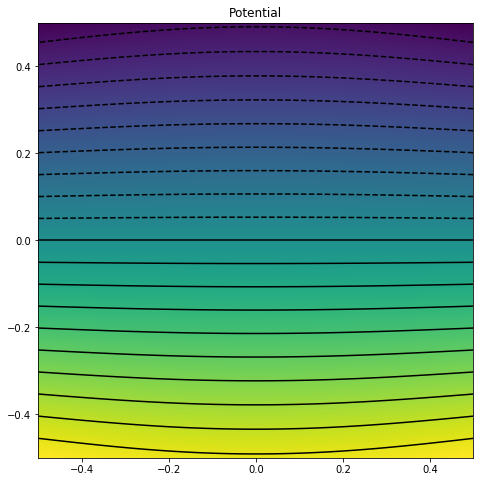

In [330]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Potential')
ax.pcolormesh(x,y,potential)
ax.contour(x, y, potential, 20, colors = 'k')
ax.set(aspect = 1);

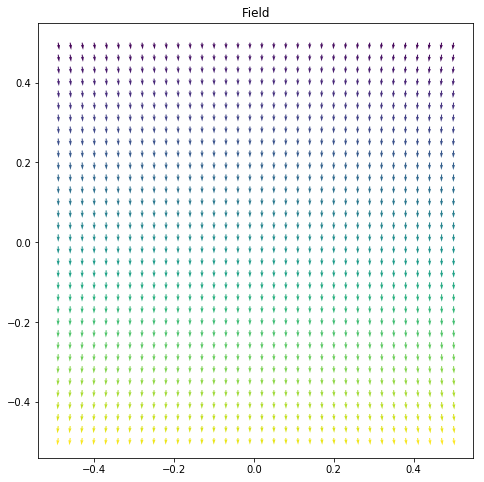

In [331]:
skip = (slice(None, None, 15), slice(None, None, 15))

fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Field')
ax.quiver(x[skip], y[skip], Ex[skip], Ey[skip], potential[skip])
ax.set(aspect=1);

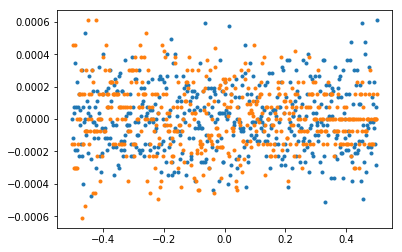

In [332]:
plt.plot(x[250,:], Ex[250,:], '.')
plt.plot(y[:,250], Ex[:,250], '.')

In [341]:
def minimize_function(charges, x, y, wires):
    w = wires.copy()
    c = np.array(list(charges)*4)*w[2,:]
    w[2,:] = c
    potential = wires_potential(x, y, w)
    Ey, Ex = np.gradient(-potential)
    EyX, EyY = Ey[51,:], Ey[51,:]
    EyT, EyR = Ey[0,:], Ey[:,0]
    ExT, ExR = Ex[0,:], Ex[:,0]
#     return EyX.ptp()/Ey[51,51]
    return (EyX**2+EyY**2+EyT**2+EyR**2).sum()/(Ey[51,51])**2

In [342]:
y,x = np.mgrid[0.5:-0.5:101j,0.5:-0.5:101j]

In [343]:
from scipy.optimize import minimize
bounds = [(0,10)]*5
x0 = [1]*5
m = minimize(minimize_function, x0 = x0, bounds = bounds, args = (x, y, wires))

In [344]:
m

      fun: 408.27140793419602
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.09141876e+00,   1.99700594e+00,   9.03031605e-01,
         3.20250138e-01,  -4.60431693e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 6
   status: 0
  success: True
        x: array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -4.44089210e-16,   6.45712855e+00])

In [345]:
w = wires.copy()
w[2,:] = w[2,:]*np.array(list(m.x)*4)
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy

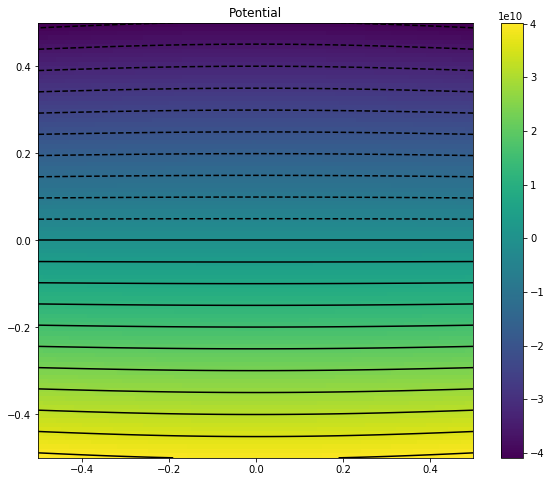

In [346]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Potential')
pc = ax.pcolormesh(x,y,potential)
ax.contour(x, y, potential, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

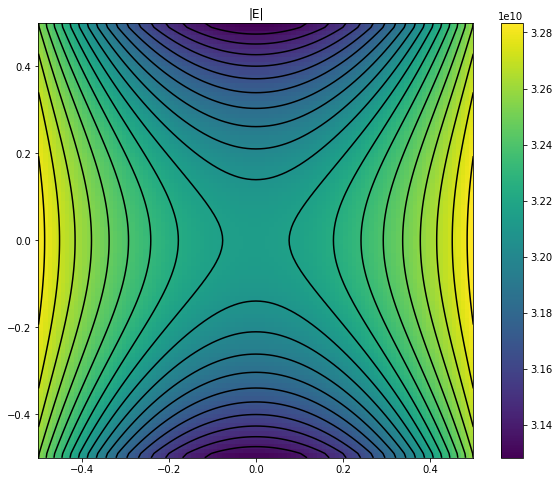

In [347]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('|E|')
pc = ax.pcolormesh(x, y, np.sqrt(Ex**2+Ey**2))
ax.contour(x, y, np.sqrt(Ex**2+Ey**2), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

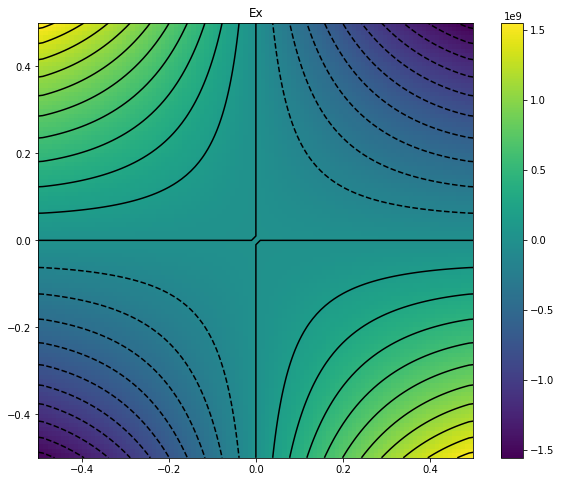

In [348]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ex')
pc = ax.pcolormesh(x, y, Ex)
ax.contour(x, y, Ex, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

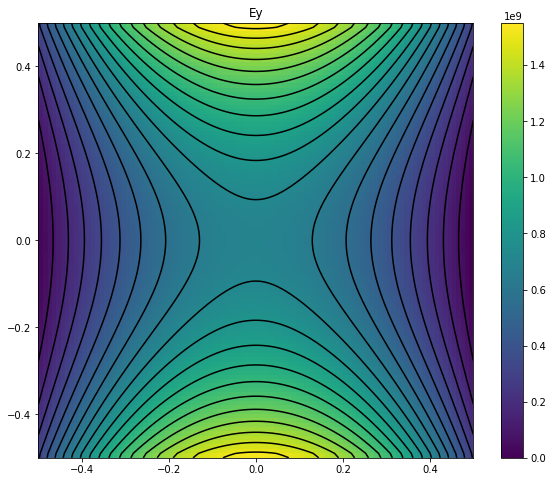

In [349]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ey')
pc = ax.pcolormesh(x, y, Ey-Ey.min())
ax.contour(x, y, Ey-Ey.min(), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

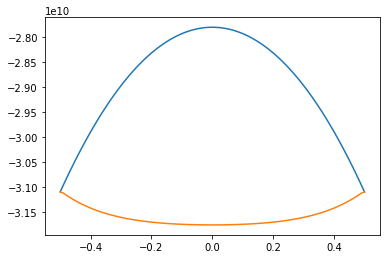

In [298]:
plt.plot(x[0,:], Ey[0,:])
plt.plot(y[:,0], Ey[:,0])

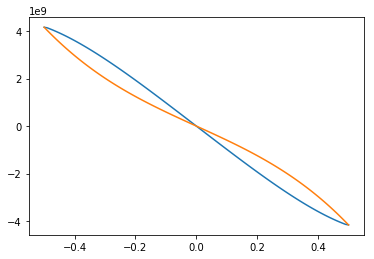

In [299]:
plt.plot(x[0,:], Ex[0,:])
plt.plot(y[:,0], Ex[:,0])